This is a journal used to create the data ingestion and processing pipeline for generating air quality index as part of the NASA Spaceapps challenge 2025. This will involve a number of steps
1. Data ingestion and formatting
2. Exploratory data analysis
3. Data transformation - Structuring data for use with typical geospatial analysis tools
4. Exporting data as geojson file

In [1]:
# Import required libraries for data fusion and geospatial analysis
import pandas as pd
import geopandas as gpd
import pyreadr
import rasterio
import matplotlib.pyplot as plt
import numpy as np      

In [2]:
# Initial testing will use the elemental carbon (EC) data from the 2019 Earth Observatory dataset. This data is formatted as an RDS file, so 
# a bit of work will be needed to convert it to a more useable format. First, we will get it into a dataframe and take a look at the structure.
# ecData = pyreadr.read_r('sourceData/aqdh_pm25component_ec_2019_urban.rds')
# ecDF = ecData[None]  # Extract the dataframe from the dictionary

# While testing, get the dataframe from the trimmed csv file
ecDF = pd.read_csv('processedData/ec_2019_ptc_trimmed.csv')
print(ecDF.describe())

                lon           lat            ec
count  87022.000000  87022.000000  87022.000000
mean     -84.216624     33.975789      0.700731
std        0.042771      0.043617      0.114809
min      -84.290701     33.900271      0.446145
25%      -84.253663     33.938013      0.625602
50%      -84.216624     33.975777      0.680784
75%      -84.179585     34.013559      0.740519
max      -84.142549     34.051360      1.360308


In [5]:
# Let's do an initial trim to narrow this down to Georgia, USA only. 
georgiaBounds = {
    "minLat": 30.219051,
    "maxLat": 35.046044,
    "minLon": -85.809632,
    "maxLon": -80.766907
}

georgiaDF = ecDF[
    (ecDF['lat'] >= georgiaBounds['minLat']) & (ecDF['lat'] <= georgiaBounds['maxLat']) &
    (ecDF['lon'] >= georgiaBounds['minLon']) & (ecDF['lon'] <= georgiaBounds['maxLon'])
]   
georgiaDF.to_csv('processedData/ec_2019_georgia.csv', index=False)

In [78]:
# Trim the data for our area of interest, using lat/long bounds for the state of Georgia, USA
minLat, maxLat = 33.900271, 34.051360
deltaLat = maxLat - minLat
# minLonStart = -83.605164
# minLon, maxLon = minLonStart, minLonStart + deltaLat * 1.5  # Approximate aspect ratio of Georgia
minLon, maxLon = -84.290703, -84.142546  # More accurate bounds for Georgia

trimmedEC = ecDF[(ecDF['lat'] >= minLat) & (ecDF['lat'] <= maxLat) & (ecDF['lon'] >= minLon) & (ecDF['lon'] <= maxLon)]

# We'll also rename the third column to something easier to work with and describe the data to get a sense of the distribution of EC values
trimmedEC = trimmedEC.rename(columns={trimmedEC.columns[2]: 'ec'})
print(trimmedEC.head())

# Let's also view the data info to get a sense of the distribution of data types and check for any missing values
print(trimmedEC.info())

# Save this trimmed file for easy testing later
trimmedEC.to_csv('processedData/ec_2019_ptc_trimmed.csv', index=False)


                 lon        lat        ec
135625306 -84.144453  34.051345  0.587143
135625307 -84.143886  34.051287  0.585369
135625308 -84.143320  34.051228  0.585541
135625309 -84.142754  34.051169  0.575837
135628377 -84.148492  34.051308  0.604220
<class 'pandas.core.frame.DataFrame'>
Index: 87022 entries, 135625306 to 136608037
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     87022 non-null  float64
 1   lat     87022 non-null  float64
 2   ec      87022 non-null  float64
dtypes: float64(3)
memory usage: 2.7 MB
None


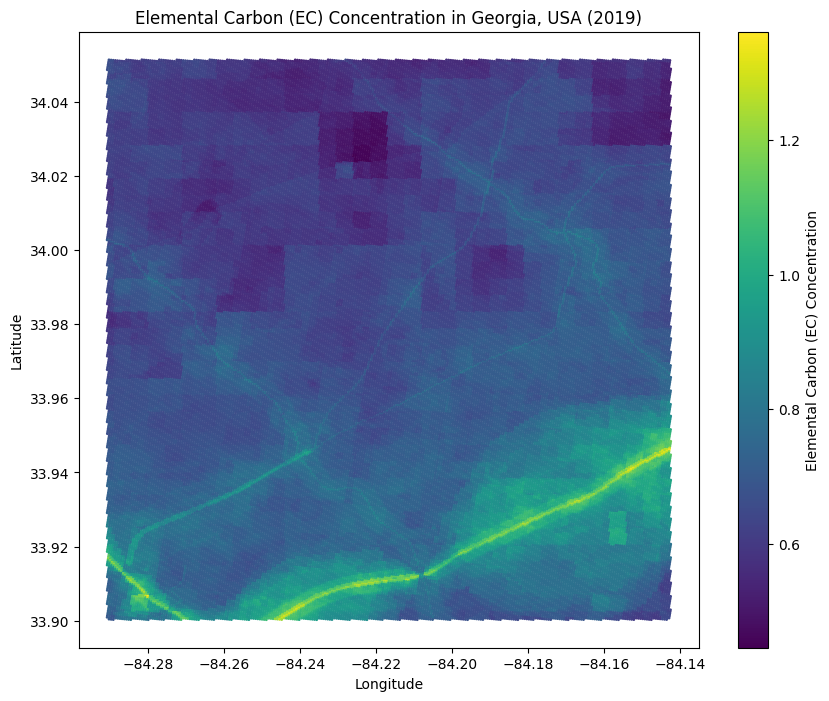

In [79]:
# The description of the data says these are grid cells with a resolution of 50m for urban areas, and 1km for rural area. We can visualize the data to confirm this.
plt.figure(figsize=(10, 8))
plt.scatter(trimmedEC['lon'], trimmedEC['lat'], c=trimmedEC['ec'], cmap='viridis', s=1)
plt.colorbar(label='Elemental Carbon (EC) Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Elemental Carbon (EC) Concentration in Georgia, USA (2019)')
plt.show()  

In [71]:
# The data looks good, and we can see the higher resolution in urban areas. Next steps will be to establish a grid 
# for interpolation and fusion with other datasets.

# We will use geopandas to create a 50m grid cell around it and assign the EC value to that cell. This will help in visualizing and analyzing the data.
geometry = gpd.points_from_xy(trimmedEC['lon'], trimmedEC['lat'])
geoDF = gpd.GeoDataFrame(trimmedEC, geometry=geometry)
geoDF.set_crs(epsg=4326, inplace=True)  # Set coordinate reference system to WGS84

# Create 25m buffer around each point to represent the grid cell
arc = 0.000225  # Approximate degree equivalent for 25m at mid-latitudes
geoDF['geometry'] = geoDF.geometry.buffer(arc)
print(geoDF.head())

C:\Users\danes\AppData\Local\Temp\ipykernel_5036\3754902243.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geoDF['geometry'] = geoDF.geometry.buffer(arc)


                 lon        lat        ec  \
135625306 -84.144453  34.051345  0.587143   
135625307 -84.143886  34.051287  0.585369   
135625308 -84.143320  34.051228  0.585541   
135625309 -84.142754  34.051169  0.575837   
135628377 -84.148492  34.051308  0.604220   

                                                    geometry  
135625306  POLYGON ((-84.14423 34.05135, -84.14423 34.051...  
135625307  POLYGON ((-84.14366 34.05129, -84.14366 34.051...  
135625308  POLYGON ((-84.14309 34.05123, -84.1431 34.0512...  
135625309  POLYGON ((-84.14253 34.05117, -84.14253 34.051...  
135628377  POLYGON ((-84.14827 34.05131, -84.14827 34.051...  


In [72]:
geoDF.describe()

# Normalize the EC values for better visualization
geoDF['ec_normalized'] = (geoDF['ec'] - geoDF['ec'].min()) / (geoDF['ec'].max() - geoDF['ec'].min())
print(geoDF[['ec', 'ec_normalized']].describe())

                 ec  ec_normalized
count  87022.000000   87022.000000
mean       0.700731       0.278490
std        0.114809       0.125589
min        0.446145       0.000000
25%        0.625602       0.196307
50%        0.680784       0.256671
75%        0.740519       0.322015
max        1.360308       1.000000


In [73]:
# Now we use use geopandas to export this as a geojson file for use in our web application
geoDF.to_file('processedData/ec_2019_georgia.geojson', driver='GeoJSON')